In [69]:
import mujoco
import numpy as np

In [70]:
# model = mujoco.MjModel.from_xml_path('myosim_convert/myo_sim/leg/myolegs.xml')
model = mujoco.MjModel.from_xml_path('myosim_convert/myo_sim/leg/myolegs_hang.xml')
data = mujoco.MjData(model)

H, W = 480, 640
renderer = mujoco.Renderer(model, height=H, width=W)


renderer._scene_option.flags[mujoco.mjtVisFlag.mjVIS_ACTUATOR] = 1

ctx = mujoco.MjrContext(model, mujoco.mjtFontScale.mjFONTSCALE_100)
frame = renderer.render()

model.opt.timestep = 1/1200
mujoco.mj_resetData(model, data)

In [ ]:
# joint_name = "knee_angle_r"
joint_name = "ankle_angle_r"
# joint_name = "subtalar_angle_r"
joint_range = model.joint(joint_name).range
joint_resolution = (joint_range[1] - joint_range[0]) / 100 / 40

# muscle_name = "gaslat_r"
# muscle_name = "gasmed_r"
muscle_name = "soleus_r"
default_actuator_id = model.actuator(muscle_name).id
dof_id = model.joint(joint_name).dofadr[0]


In [72]:
frames = []

data.joint(joint_name).qpos = joint_range[0]

mujoco.mj_forward(model, data)

print(f'{data.actuator(muscle_name).length[0]=}')


datas = {}

datas['ctrl_default'] = []
datas['frc_default'] = []
datas['actuator_force_default'] = []
datas['moment_arm_default'] = []
datas['torque_default'] = []
datas['sensor_frc_default'] = []
datas['activation_default'] = []
datas['len_default'] = []
datas['qpos_default'] = []
datas['qvel_default'] = []


for idx in range(100):
    for sim_step in range(40):

        
        # data.actuator(muscle_name).length[0] = 0.0
        data.joint(joint_name).qpos += joint_resolution
        data.joint(joint_name).qvel = 0.1

        data.ctrl[default_actuator_id] = 1.0
        data.act[default_actuator_id] = 1.0

        
        mujoco.mj_forward(model, data)
        # mujoco.mj_step(model, data)

        datas["ctrl_default"].append(data.actuator(muscle_name).ctrl[0])
        # datas["frc_default"].append(data.qfrc_actuator[default_actuator_id].copy())
        force = data.actuator(muscle_name).force
        datas["frc_default"].append(-force)
        datas["actuator_force_default"].append(-data.qfrc_actuator[dof_id].copy())
        datas["activation_default"].append(data.act[default_actuator_id].copy())

        moment_arm = data.actuator(muscle_name).moment[dof_id].copy()
        datas["moment_arm_default"].append(moment_arm)
        torque = force * moment_arm
        datas["torque_default"].append(torque)
        # datas["sensor_frc_default"].append(data.sensor("frc_r").data[0])
        datas["qpos_default"].append(data.joint(joint_name).qpos[0])
        datas["qvel_default"].append(data.joint(joint_name).qvel[0])
        datas["len_default"].append(data.actuator(muscle_name).length[0])



    renderer.update_scene(data, camera=0)
    frame = renderer.render()
    frames.append(frame.copy())
print(f'{data.actuator(muscle_name).length[0]=}')
renderer.close()

data.actuator(muscle_name).length[0]=np.float64(0.4139978790212289)
data.actuator(muscle_name).length[0]=np.float64(0.4139978790212289)


In [73]:
data.actuator(muscle_name).force

array([-1319.81541767])

In [74]:
data.qfrc_actuator

array([-4.46691470e+01,  2.24513388e+01, -6.32778377e+00,  4.09427504e+02,
        2.48182982e+03,  6.08173810e+01, -3.65120211e+01,  3.22041686e+00,
       -4.08731340e+01,  5.46721481e+00,  1.75722193e-02, -9.42632917e+02,
       -1.84998400e+01,  6.73407869e+00,  2.01293387e+01, -9.02284164e+00,
       -6.39638869e-01,  1.06521323e+02,  7.17247329e+02,  4.80683277e+00,
       -2.86237493e-01,  2.68212892e-01, -7.27116853e+00,  5.65894762e-01,
       -1.19869609e-03, -1.03227443e+03, -2.02591183e+01,  7.37446901e+00])

In [75]:
data.actuator(muscle_name).moment

array([-9.91089124e-01, -3.46509214e-02, -1.97832555e-02, -8.74598390e-04,
        4.83997646e-02, -2.57390196e-02, -5.03242276e-04, -1.05213080e-01,
       -9.91908358e-01, -4.06237304e-02, -2.48423173e-02, -2.74789579e-04,
       -3.17503117e-19, -5.20417043e-18,  1.95156391e-18,  2.93751980e-02,
       -4.29190883e-03, -2.72294581e-02,  5.31602202e-02, -6.30031902e-04,
       -1.21709029e-01, -9.91422121e-01,  1.06810082e-02,  3.34556048e-02,
       -3.59387971e-03,  1.04083409e-17, -2.61514429e-18, -9.71445147e-17])

In [76]:
moment_arm = data.actuator(muscle_name).moment[dof_id]
print(f'{moment_arm=}')

moment_arm=np.float64(-0.9919083575962953)


In [77]:
import imageio
video_path = "dummy.mp4"
imageio.mimsave(video_path, frames, fps=30)
from IPython.display import Video, display
display(Video(video_path, embed=True))

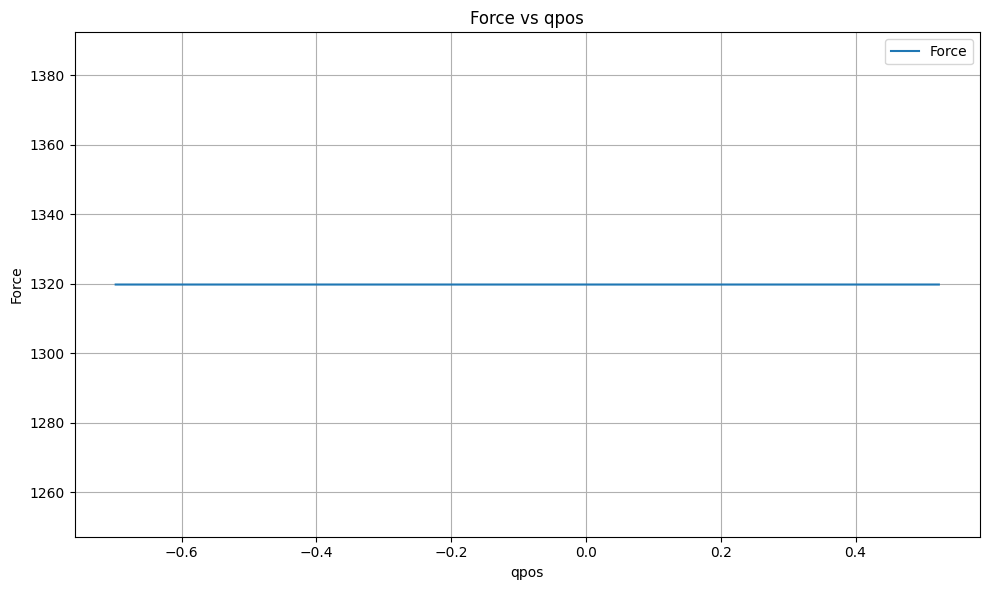

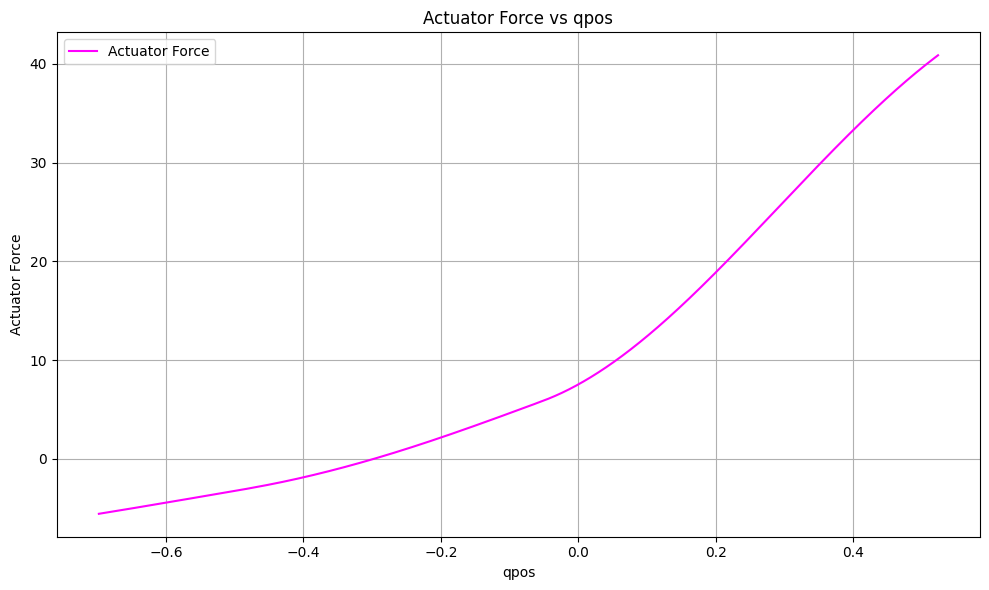

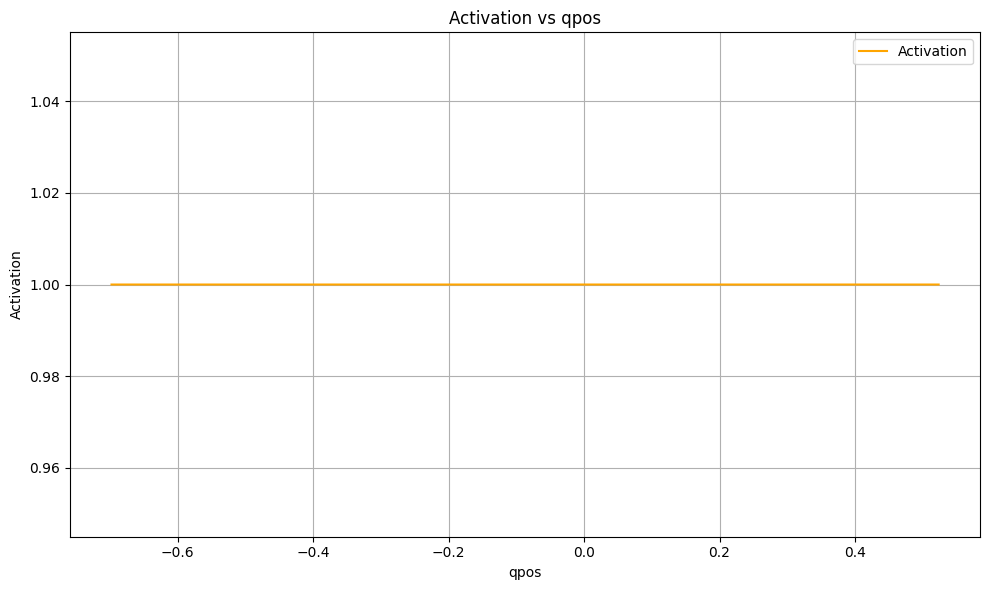

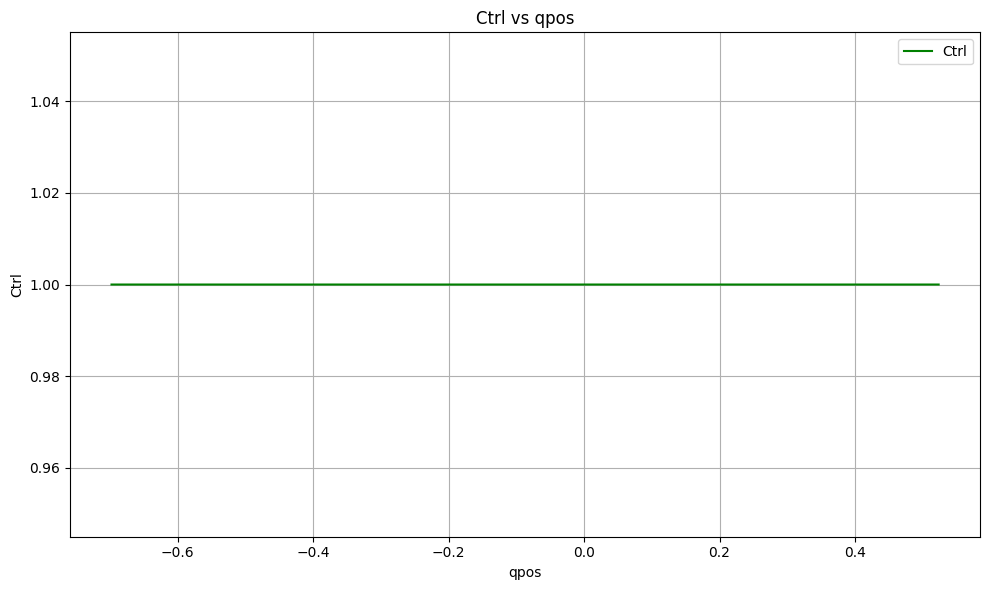

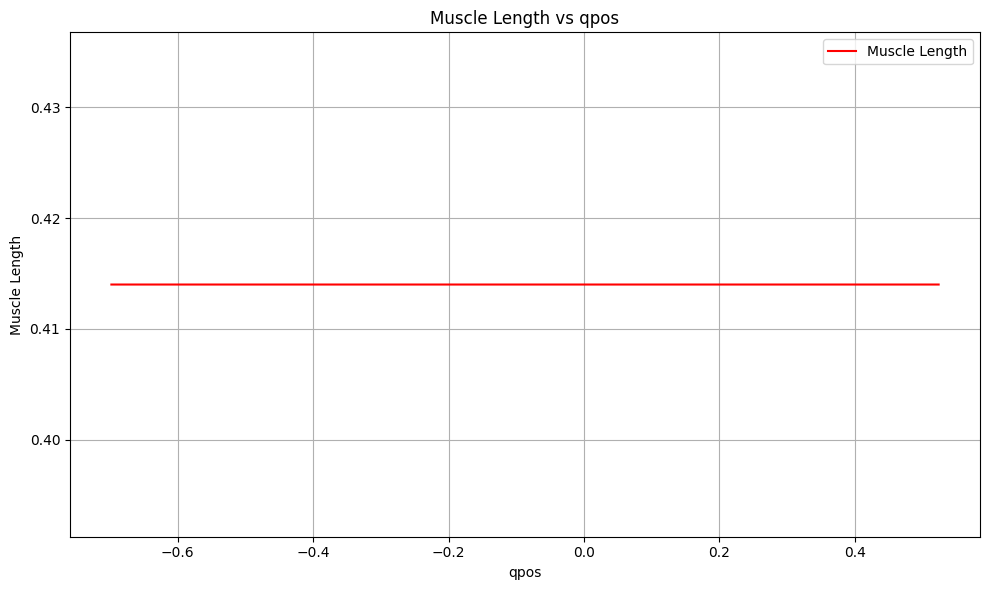

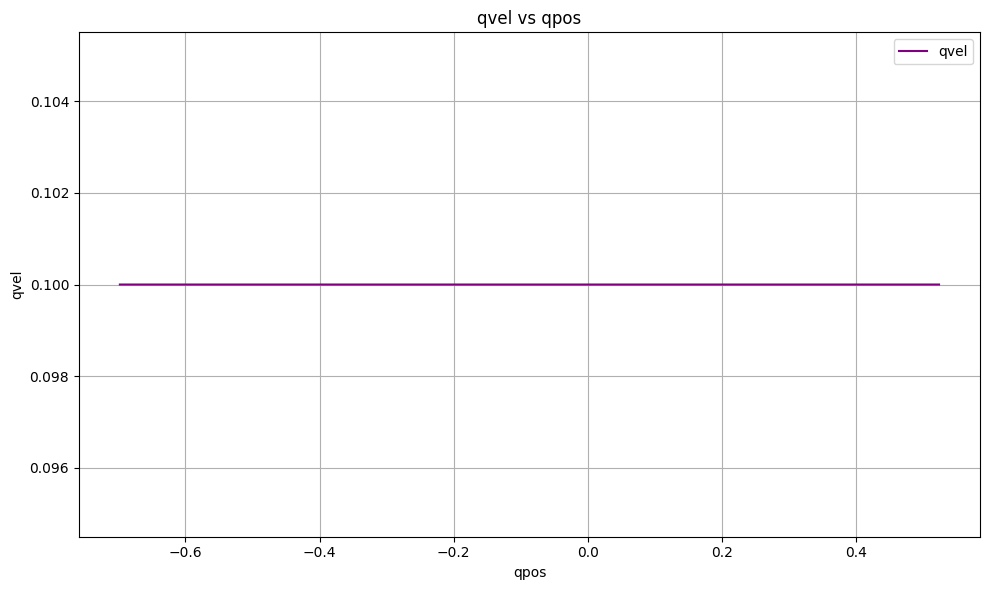

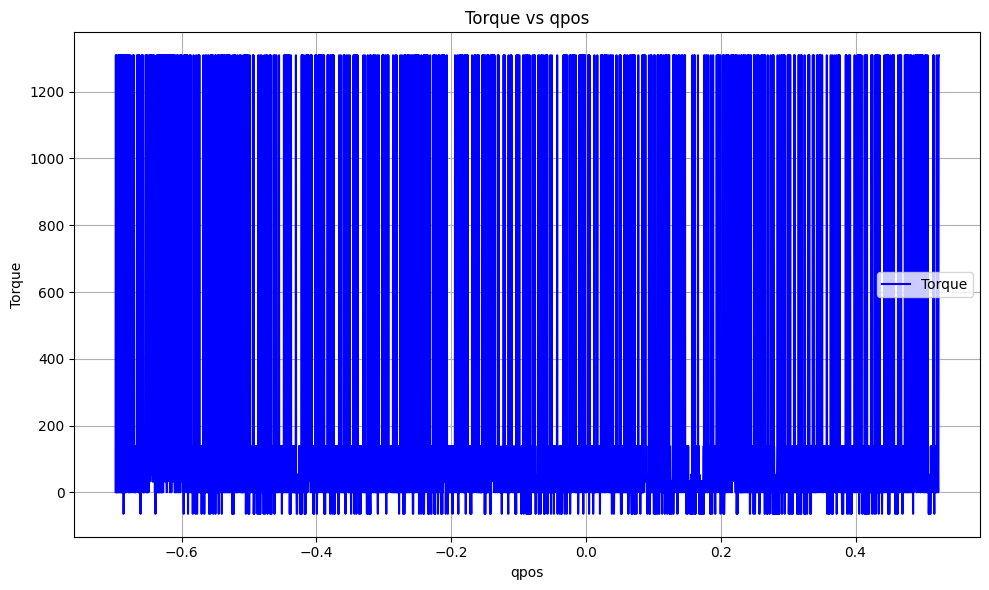

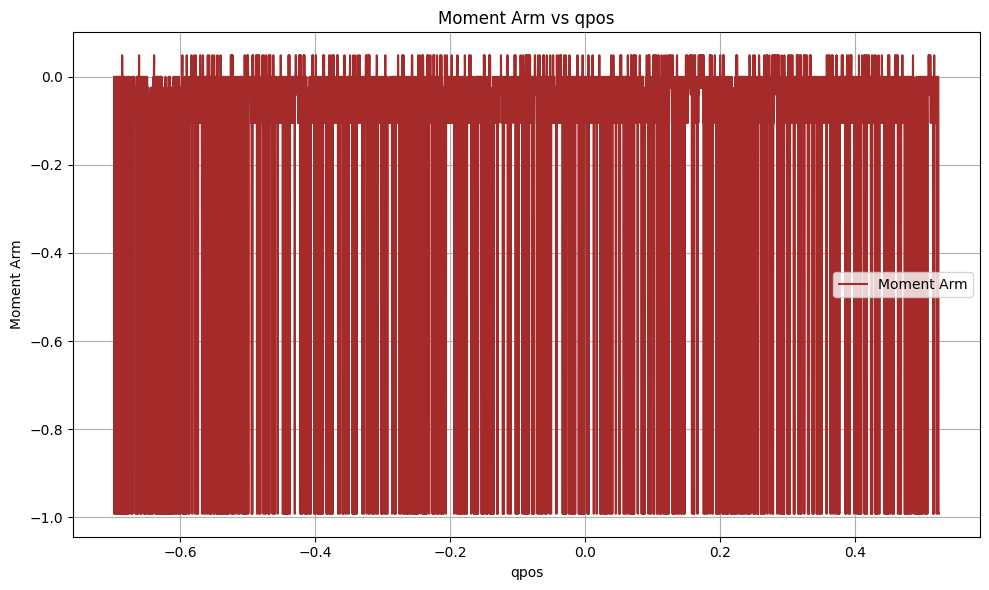

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
qpos = np.array(datas['qpos_default'])
force = np.array(datas['frc_default'])
activation = np.array(datas['activation_default'])
ctrl = np.array(datas['ctrl_default'])
length = np.array(datas['len_default'])
qvel = np.array(datas['qvel_default'])
actuator_force = np.array(datas['actuator_force_default'])  # actuator force
torque = np.array(datas['torque_default'])  # Torque
moment_arm = np.array(datas['moment_arm_default'])  # Moment arm

# Plot Force vs qpos
plt.figure(figsize=(10, 6))
plt.plot(qpos, force, label='Force')
plt.xlabel('qpos')
plt.ylabel('Force')
plt.title('Force vs qpos')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Actuator Force vs qpos (separate)
plt.figure(figsize=(10, 6))
plt.plot(qpos, actuator_force, label='Actuator Force', color='magenta')
plt.xlabel('qpos')
plt.ylabel('Actuator Force')
plt.title('Actuator Force vs qpos')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Activation vs qpos
plt.figure(figsize=(10, 6))
plt.plot(qpos, activation, label='Activation', color='orange')
plt.xlabel('qpos')
plt.ylabel('Activation')
plt.title('Activation vs qpos')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Ctrl vs qpos
plt.figure(figsize=(10, 6))
plt.plot(qpos, ctrl, label='Ctrl', color='green')
plt.xlabel('qpos')
plt.ylabel('Ctrl')
plt.title('Ctrl vs qpos')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Muscle Length vs qpos
plt.figure(figsize=(10, 6))
plt.plot(qpos, length, label='Muscle Length', color='red')
plt.xlabel('qpos')
plt.ylabel('Muscle Length')
plt.title('Muscle Length vs qpos')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot qvel vs qpos
plt.figure(figsize=(10, 6))
plt.plot(qpos, qvel, label='qvel', color='purple')
plt.xlabel('qpos')
plt.ylabel('qvel')
plt.title('qvel vs qpos')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Torque vs qpos
plt.figure(figsize=(10, 6))
plt.plot(qpos, torque, label='Torque', color='blue')
plt.xlabel('qpos')
plt.ylabel('Torque')
plt.title('Torque vs qpos')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Moment Arm vs qpos
plt.figure(figsize=(10, 6))
plt.plot(qpos, moment_arm, label='Moment Arm', color='brown')
plt.xlabel('qpos')
plt.ylabel('Moment Arm')
plt.title('Moment Arm vs qpos')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [79]:
moment_arm.shape

(4000,)

In [80]:
np.min(moment_arm)

np.float64(-0.9919083575962953)